# Tentativa com Docling

In [ ]:
!pip install torch docling --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 39.6 MB/s eta 0:00:00
 

In [ ]:
!pip install docling stanza ufal.udpipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 39.7 MB/s eta 0:00:00


In [ ]:
import csv
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from collections import Counter

from docling.document_converter import DocumentConverter

In [ ]:
import urllib.request
import zipfile
import os
from ufal.udpipe import Model, Pipeline

In [ ]:
url = "https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.5/master/inst/udpipe-ud-2.5-191206/portuguese-gsd-ud-2.5-191206.udpipe"
udpipe_model_path = "portuguese-gsd-ud-2.5-191206.udpipe"

urllib.request.urlretrieve(url, udpipe_model_path)

print("Modelo baixado em:", udpipe_model_path)

Modelo baixado em: portuguese-gsd-ud-2.5-191206.udpipe


In [ ]:
INPUT_PDF = "/content/drive/MyDrive/IC/SIREVA/sireva_2023.pdf"

OUT_DIR = Path("saida_corpus")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
converter = DocumentConverter()

In [ ]:
def carregar_docling(source: str):
    """
    Converte um PDF/URL usando Docling e retorna o DoclingDocument.
    """
    result = converter.convert(source)
    return result.document


def exportar_texto_corrigido(doc, out_dir: Path) -> Path:
    """
    Exporta o texto "corrigido" (linearizado) do Docling para um .txt.
    Esse texto eh o corpus "normal" (paragrafos, conclusoes, etc.).
    """
    texto = doc.export_to_text()
    caminho = out_dir / "texto_corrigido.txt"
    caminho.write_text(texto, encoding="utf-8")
    print(f"[OK] Texto corrido salvo em {caminho}")
    return caminho


def exportar_tabelas_para_csv(doc, out_dir: Path) -> List[Path]:
    """
    Exporta as tabelas do Docling para arquivos CSV usando a API oficial:
      doc.tables  +  table.export_to_dataframe(doc=doc)
    """
    tabelas_csv = []
    tabelas_dir = out_dir / "tabelas_csv"
    tabelas_dir.mkdir(exist_ok=True)

    # doc.tables eh a forma correta de acessar as tabelas
    if not hasattr(doc, "tables") or not doc.tables:
        print("[AVISO] Nenhuma tabela encontrada em doc.tables.")
        return tabelas_csv

    for idx, table in enumerate(doc.tables, start=1):
        # Cada 'table' eh um TableItem; tentando usar o helper para virar DataFrame
        df = table.export_to_dataframe(doc=doc)

        csv_path = tabelas_dir / f"tabela_{idx:02d}.csv"
        df.to_csv(csv_path, index=False)
        tabelas_csv.append(csv_path)
        print(f"[OK] Tabela {idx} salva em {csv_path}")

    return tabelas_csv

In [ ]:
def linha_para_frase(headers: List[str],
                     row: List[str],
                     tabela_id: str,
                     row_idx: int) -> str:
    """
    Transforma uma linha de tabela em uma frase em portugues.

    Exemplo:
    headers = ["Ano", "Região", "Sorotipo", "Casos"]
    row     = ["2023", "Sudeste", "19A", "12"]

    -> "Na tabela T1, linha 1, Ano eh 2023, Região eh Sudeste, Sorotipo eh 19A, Casos eh 12."
    """
    pares = []
    for h, v in zip(headers, row):
        h_clean = (h or "").strip()
        v_clean = (str(v) or "").strip()
        if h_clean and v_clean:
            pares.append(f"{h_clean} é {v_clean}")

    if not pares:
        return f"Na tabela {tabela_id}, linha {row_idx}, nao ha dados relevantes."

    fatos = ", ".join(pares)
    frase = f"Na tabela {tabela_id}, linha {row_idx}, {fatos}."
    return frase


def gerar_frases_linearizadas(tabelas_csv: List[Path], out_dir: Path) -> Path:
    """
    Le todos os CSVs de tabelas, gera frases linearizadas e
    salva em um unico arquivo de texto.
    """
    frases = []

    for t_idx, csv_path in enumerate(tabelas_csv, start=1):
        tabela_id = f"T{t_idx}"
        with csv_path.open("r", encoding="utf-8") as f:
            reader = csv.reader(f)
            rows = list(reader)

        if not rows:
            continue

        headers = rows[0]
        for r_idx, row in enumerate(rows[1:], start=1):
            frase = linha_para_frase(headers, row, tabela_id, r_idx)
            frases.append(frase)

    texto_linearizado = "\n".join(frases)

    out_path = out_dir / "tabelas_linearizadas.txt"
    out_path.write_text(texto_linearizado, encoding="utf-8")
    print(f"[OK] Frases linearizadas salvas em {out_path}")
    return out_path


def preparar_arquivos_para_parsers(texto_corrigido: Path,
                                   tabelas_linearizadas: Path,
                                   out_dir: Path):
    """
    Junta texto corrido + frases das tabelas e gera 3 arquivos identicos:
      - corpus_spacy.txt
      - corpus_stanza.txt
      - corpus_udpipe.txt
    """
    texto_corrido = texto_corrigido.read_text(encoding="utf-8")
    texto_tab = tabelas_linearizadas.read_text(encoding="utf-8")

    corpus_unificado = texto_corrido + "\n\n" + texto_tab + "\n"

    spacy_path = out_dir / "corpus_spacy.txt"
    stanza_path = out_dir / "corpus_stanza.txt"
    udpipe_path = out_dir / "corpus_udpipe.txt"

    for path in [spacy_path, stanza_path, udpipe_path]:
        path.write_text(corpus_unificado, encoding="utf-8")
        print(f"[OK] Corpus salvo para {path.name}")

    return spacy_path, stanza_path, udpipe_path

In [ ]:
def rodar_spacy(caminho_corpus: Path, modelo: str = "pt_core_news_lg"):
    """
    Exemplo simples de como rodar spaCy no corpus.
    """
    import spacy
    from pathlib import Path as _Path

    nlp = spacy.load(modelo)
    texto = _Path(caminho_corpus).read_text(encoding="utf-8")

    print("[spaCy] Processando corpus...")
    doc = nlp(texto)

    print(f"[spaCy] Numero de tokens: {len(doc)}")
    return doc


def rodar_stanza(caminho_corpus: Path, lang: str = "pt"):
    """
    Exemplo simples com Stanza.
    """
    import stanza
    from pathlib import Path as _Path

    stanza.download(lang)
    nlp = stanza.Pipeline(lang=lang)
    texto = _Path(caminho_corpus).read_text(encoding="utf-8")

    print("[Stanza] Processando corpus...")
    doc = nlp(texto)

    # doc.sentences, doc.sentences[0].words etc.
    print(f"[Stanza] Numero de sentencas: {len(doc.sentences)}")
    return doc


def rodar_udpipe(caminho_corpus: Path,
                 modelo_path: str = "pt-ud-2.5-udpipe.udpipe"):
    """
    Exemplo simples com UDPipe.
    Voce precisa baixar o modelo .udpipe antes e apontar o caminho.
    """
    from ufal.udpipe import Model, Pipeline
    from pathlib import Path as _Path

    model = Model.load(modelo_path)
    if not model:
        raise RuntimeError(f"Nao foi possível carregar o modelo UDPipe em {modelo_path}")

    pipeline = Pipeline(model,
                        "tokenize",
                        Pipeline.DEFAULT,
                        Pipeline.DEFAULT,
                        "conllu")
    texto = _Path(caminho_corpus).read_text(encoding="utf-8")

    print("[UDPipe] Processando corpus...")
    conllu = pipeline.process(texto)

    out_conllu = OUT_DIR / "corpus_udpipe.conllu"
    out_conllu.write_text(conllu, encoding="utf-8")
    print(f"[UDPipe] Saida CONLL-U salva em {out_conllu}")

    return conllu

In [ ]:
def main():
    doc = carregar_docling(INPUT_PDF)

    texto_corrigido_path = exportar_texto_corrigido(doc, OUT_DIR)

    tabelas_csv = exportar_tabelas_para_csv(doc, OUT_DIR)

    if not tabelas_csv:
        print("[AVISO] Nenhuma tabela exportada. Vamos gerar apenas o corpus de texto.")
        # mesmo assim cria arquivos para parsers so com texto
        preparar_arquivos_para_parsers(texto_corrigido_path,
                                       texto_corrigido_path,  # gambiarra: mesmo arquivo
                                       OUT_DIR)
        return

    tabelas_linearizadas_path = gerar_frases_linearizadas(tabelas_csv, OUT_DIR)

    spacy_path, stanza_path, udpipe_path = preparar_arquivos_para_parsers(
        texto_corrigido_path,
        tabelas_linearizadas_path,
        OUT_DIR
    )

    print("\n=== Caminhos finais dos corpora ===")
    print("spaCy:   ", spacy_path)
    print("Stanza:  ", stanza_path)
    print("UDPipe:  ", udpipe_path)

In [ ]:
if __name__ == "__main__":
    main()

[INFO] 2025-12-02 12:57:00,203 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-12-02 12:57:00,215 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/torch/PP-OCRv4/det/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-02 12:57:02,288 [RapidOCR] download_file.py:82: Download size: 13.83MB
[INFO] 2025-12-02 12:57:02,670 [RapidOCR] download_file.py:95: Successfully saved to: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-02 12:57:02,673 [RapidOCR] torch.py:54: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.pth
[INFO] 2025-12-02 12:57:03,759 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-12-02 12:57:03,761 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/torch/PP-OCRv4/cls/ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-12-02 12:57:04,889 [RapidOCR] downlo

[OK] Texto corrido salvo em saida_corpus/texto_corrigido.txt
[OK] Tabela 1 salva em saida_corpus/tabelas_csv/tabela_01.csv
[OK] Tabela 2 salva em saida_corpus/tabelas_csv/tabela_02.csv
[OK] Tabela 3 salva em saida_corpus/tabelas_csv/tabela_03.csv
[OK] Tabela 4 salva em saida_corpus/tabelas_csv/tabela_04.csv
[OK] Tabela 5 salva em saida_corpus/tabelas_csv/tabela_05.csv
[OK] Tabela 6 salva em saida_corpus/tabelas_csv/tabela_06.csv
[OK] Tabela 7 salva em saida_corpus/tabelas_csv/tabela_07.csv
[OK] Tabela 8 salva em saida_corpus/tabelas_csv/tabela_08.csv
[OK] Tabela 9 salva em saida_corpus/tabelas_csv/tabela_09.csv
[OK] Tabela 10 salva em saida_corpus/tabelas_csv/tabela_10.csv
[OK] Tabela 11 salva em saida_corpus/tabelas_csv/tabela_11.csv
[OK] Tabela 12 salva em saida_corpus/tabelas_csv/tabela_12.csv
[OK] Tabela 13 salva em saida_corpus/tabelas_csv/tabela_13.csv
[OK] Tabela 14 salva em saida_corpus/tabelas_csv/tabela_14.csv
[OK] Tabela 15 salva em saida_corpus/tabelas_csv/tabela_15.csv
[OK

In [ ]:
df1 = pd.read_csv("saida_corpus/tabelas_csv/tabela_01.csv")
df1.head()

,0
0,Sumário
1,Introdução.......................................
2,Haemophilus influenzae ..........................
3,Tabela 1. Número de isolados invasivos por gru...
4,Haemophilus influenzae ..........................


In [ ]:
df1.shape

(32, 1)

## Tentativa de visualizacao: Spacy

In [ ]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 764.4 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

In [ ]:
corpus_spacy_path = Path("saida_corpus/corpus_spacy.txt")
texto_spacy = corpus_spacy_path.read_text(encoding="utf-8")

nlp_spacy = spacy.load("pt_core_news_lg")
doc_spacy = nlp_spacy(texto_spacy)

In [ ]:
print("Numero de sentencas:", len(list(doc_spacy.sents)))

Numero de sentencas: 8707


In [ ]:
from spacy import displacy

In [ ]:
idx_sentenca = 1

sent = list(doc_spacy.sents)[idx_sentenca]
print(sent.text)

displacy.render(sent, style="dep", jupyter=True, options={"compact": True})


SECRETARIA DE ESTADO DA SAÚDE COORDENADORIA DE CONTROLE DE DOENÇAS


In [ ]:
idx_sentenca = 2

sent = list(doc_spacy.sents)[idx_sentenca]
print(sent.text)

displacy.render(sent, style="dep", jupyter=True, options={"compact": True})

INSTITUTO ADOLFO LUTZ

##


In [ ]:
texto_corrigido_path = Path("saida_corpus/texto_corrigido.txt")
tabelas_lin_path     = Path("saida_corpus/tabelas_linearizadas.txt")

In [ ]:
texto_corrigido = texto_corrigido_path.read_text(encoding="utf-8")
texto_tabelas   = tabelas_lin_path.read_text(encoding="utf-8")

In [ ]:
nlp = spacy.load("pt_core_news_lg")

In [ ]:
PRINCIPAIS_POS = ["NOUN", "PROPN", "VERB", "ADJ", "NUM"]

def sent_stats_spacy(texto: str, origem: str):
    """
    Gera um DataFrame com uma linha por sentença:
    - texto da sentença
    - tamanho (n_tokens)
    - contagem de NOUN, PROPN, VERB, ADJ, NUM
    - nº de tokens maiúsculos
    - nº de tokens maiúsculos que NÃO são PROPN
    - coluna 'origem' (texto_corrigido ou tabelas)
    """
    doc = nlp(texto)
    linhas = []

    for i, sent in enumerate(doc.sents):
        tokens = [t for t in sent if not t.is_space]
        n_tokens = len(tokens)

        pos_counts = Counter(t.pos_ for t in tokens)

        # maiusculas
        upper_tokens = [t for t in tokens if t.text.isupper() and not t.is_punct]
        upper_not_propn = [t for t in upper_tokens if t.pos_ != "PROPN"]

        linha = {
            "origem": origem,
            "sent_id": i,
            "sent_text": sent.text.strip(),
            "n_tokens": n_tokens,
            "n_upper": len(upper_tokens),
            "n_upper_not_propn": len(upper_not_propn),
        }

        # adiciona contagem das principais POS
        for pos in PRINCIPAIS_POS:
            linha[f"n_{pos}"] = pos_counts.get(pos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

In [ ]:
texto_corrigido = Path("saida_corpus/texto_corrigido.txt").read_text(encoding="utf-8")
texto_tabelas   = Path("saida_corpus/tabelas_linearizadas.txt").read_text(encoding="utf-8")

df_texto   = sent_stats_spacy(texto_corrigido, origem="texto_corrigido")
df_tabelas = sent_stats_spacy(texto_tabelas,   origem="tabelas_linearizadas")

df_texto.head(), df_tabelas.head()

(            origem  sent_id  \
 0  texto_corrigido        0   
 1  texto_corrigido        1   
 2  texto_corrigido        2   
 3  texto_corrigido        3   
 4  texto_corrigido        4   
 
                                            sent_text  n_tokens  n_upper  \
 0                                                 ##         2        0   
 1  SECRETARIA DE ESTADO DA SAÚDE COORDENADORIA DE...        10       10   
 2                        INSTITUTO ADOLFO LUTZ\n\n##         5        3   
 3  Informação da vigilância das pneumonias e meni...        10        0   
 4  Sumário                                       ...         4        0   
 
    n_upper_not_propn  n_NOUN  n_PROPN  n_VERB  n_ADJ  n_NUM  
 0                  0       0        2       0      0      0  
 1                  4       1        6       0      0      0  
 2                  1       1        4       0      0      0  
 3                  0       4        0       0      1      1  
 4                  0       1    

In [ ]:
out_dir = Path("saida_corpus")

df_texto.to_excel(out_dir / "spacy_sentencas_texto.xlsx", index=False)
df_tabelas.to_excel(out_dir / "spacy_sentencas_tabelas.xlsx", index=False)

## Stanza

In [ ]:
import stanza

In [ ]:
stanza.download("pt")

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: pt (Portuguese) ...


INFO:stanza:Downloaded file to /root/stanza_resources/pt/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [ ]:
nlp_stz = stanza.Pipeline(lang="pt")

texto = Path("saida_corpus/corpus_stanza.txt").read_text(encoding="utf-8")
doc_stz = nlp_stz(texto)

print("Sentenças:", len(doc_stz.sentences))
print("Primeira sentença:")
print(" ".join([w.text for w in doc_stz.sentences[0].words]))

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: pt (Portuguese):
| Processor    | Package         |
----------------------------------
| tokenize     | bosque          |
| mwt          | bosque          |
| pos          | bosque_charlm   |
| lemma        | bosque_nocharlm |
| constituency | cintil_charlm   |
| depparse     | bosque_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


Sentenças: 7041
Primeira sentença:
## SECRETARIA DE ESTADO DE A SAÚDE COORDENADORIA DE CONTROLE DE DOENÇAS INSTITUTO ADOLFO LUTZ


In [ ]:
idx_sentenca = 1

sent = doc_stz.sentences[idx_sentenca]
print("Sentenca:")
print(" ".join([w.text for w in sent.words]))
print("\nDependencias (head, deprel):")
sent.print_dependencies()

Sentenca:
## Informação de a vigilância de as pneumonias e meningites bacterianas

Dependencias (head, deprel):
('##', 2, 'punct')
('Informação', 0, 'root')
('de', 5, 'case')
('a', 5, 'det')
('vigilância', 2, 'nmod')
('de', 8, 'case')
('as', 8, 'det')
('pneumonias', 5, 'nmod')
('e', 10, 'cc')
('meningites', 8, 'conj')
('bacterianas', 10, 'amod')


In [ ]:
texto_corrigido = Path("saida_corpus/texto_corrigido.txt").read_text(encoding="utf-8")
texto_tabelas   = Path("saida_corpus/tabelas_linearizadas.txt").read_text(encoding="utf-8")

In [ ]:
PRINCIPAIS_UPOS = ["NOUN", "PROPN", "VERB", "ADJ", "NUM"]

In [ ]:
def sent_stats_stanza(texto: str, origem: str) -> pd.DataFrame:
    """
    Gera um DataFrame com uma linha por sentenca anotada pelo Stanza.
    origem = "texto_corrigido" ou "tabelas_linearizadas"
    """
    doc = nlp_stz(texto)
    linhas = []

    for i, sent in enumerate(doc.sentences):
        words = sent.words   # tokens com upos, deprel, etc.

        n_tokens = len(words)
        upos_counts = Counter(w.upos for w in words)

        # maiúsculas
        upper_words = [w for w in words if w.text.isupper()]
        upper_not_propn = [w for w in upper_words if w.upos != "PROPN"]

        linha = {
            "origem": origem,
            "sent_id": i,
            "sent_text": " ".join(w.text for w in words),
            "n_tokens": n_tokens,
            "n_upper": len(upper_words),
            "n_upper_not_propn": len(upper_not_propn),
        }

        # contagem por UPOS
        for upos in PRINCIPAIS_UPOS:
            linha[f"n_{upos}"] = upos_counts.get(upos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

In [ ]:
df_texto_stz   = sent_stats_stanza(texto_corrigido, origem="texto_corrigido")
df_tabelas_stz = sent_stats_stanza(texto_tabelas,   origem="tabelas_linearizadas")

df_texto_stz.head(), df_tabelas_stz.head()

(            origem  sent_id  \
 0  texto_corrigido        0   
 1  texto_corrigido        1   
 2  texto_corrigido        2   
 3  texto_corrigido        3   
 4  texto_corrigido        4   
 
                                            sent_text  n_tokens  n_upper  \
 0  ## SECRETARIA DE ESTADO DE A SAÚDE COORDENADOR...        15       14   
 1  ## Informação de a vigilância de as pneumonias...        11        0   
 2                                               2023         1        0   
 3  | Sumário | |---------------------------------...         7        0   
 4  .................................................        13        0   
 
    n_upper_not_propn  n_NOUN  n_PROPN  n_VERB  n_ADJ  n_NUM  
 0                 12       6        2       0      1      0  
 1                  0       4        0       0      1      0  
 2                  0       0        0       0      0      1  
 3                  0       2        0       0      0      0  
 4                  0       0    

In [ ]:
out_dir = Path("saida_corpus")

df_texto_stz.to_excel(out_dir / "stanza_sentencas_texto.xlsx", index=False)
df_tabelas_stz.to_excel(out_dir / "stanza_sentencas_tabelas.xlsx", index=False)

## UDPipe

In [ ]:
!pip install conllu

In [ ]:
from collections import Counter
from conllu import parse

### Teste basico

In [ ]:
from ufal.udpipe import Model, Pipeline

modelo_path = "portuguese-gsd-ud-2.5-191206.udpipe"

model = Model.load(modelo_path)
if not model:
    raise RuntimeError(f"Não foi possível carregar o modelo em {modelo_path}")

pipeline = Pipeline(
    model,
    "tokenize",        # etapa 1: tokenizacao
    Pipeline.DEFAULT,  # etapa 2: tagging (POS, feats)
    Pipeline.DEFAULT,  # etapa 3: parsing (dependencias)
    "conllu"           # formato de saida
)

texto_teste = "eh um teste do udp em portugues"
conllu_teste = pipeline.process(texto_teste)
print(conllu_teste)

# newdoc
# newpar
# sent_id = 1
# text = eh um teste do udp em portugues
1	eh	_	NOUN	NOUN	_	0	root	_	_
2	um	_	DET	DET	_	3	det	_	_
3	teste	teste	NOUN	NOUN	_	1	obj	_	_
4-5	do	_	_	_	_	_	_	_	_
4	de	de	ADP	ADP	_	6	case	_	_
5	o	o	DET	DET	Definite=Def|Gender=Masc|Number=Sing|PronType=Art	6	det	_	_
6	udp	_	NOUN	NOUN	_	3	nmod	_	_
7	em	_	ADP	ADP	_	8	case	_	_
8	portugues	portugue	NOUN	NOUN	_	1	nmod	_	SpacesAfter=\n




In [ ]:
texto_corrigido = Path("saida_corpus/texto_corrigido.txt").read_text(encoding="utf-8")
texto_tabelas   = Path("saida_corpus/tabelas_linearizadas.txt").read_text(encoding="utf-8")

print("Tamanho texto_corrigido:", len(texto_corrigido))
print("Tamanho tabelas_linearizadas:", len(texto_tabelas))

Tamanho texto_corrigido: 252259
Tamanho tabelas_linearizadas: 327523


In [ ]:
def processar_em_chunks(texto: str, max_chars: int = 20000) -> str:
    saidas = []
    n = len(texto)
    inicio = 0

    while inicio < n:
        fim = min(inicio + max_chars, n)
        subtexto = texto[inicio:fim]
        conllu_parte = pipeline.process(subtexto)
        saidas.append(conllu_parte)
        print(f"[UDPipe] chunk {inicio}–{fim} processado")
        inicio = fim

    return "\n".join(saidas)

In [ ]:
out_dir = Path("saida_corpus")
out_dir.mkdir(exist_ok=True, parents=True)

# texto corrido
conllu_texto = processar_em_chunks(texto_corrigido, max_chars=20000)
ud_texto_path = out_dir / "ud_texto.conllu"
ud_texto_path.write_text(conllu_texto, encoding="utf-8")
print("CoNLL-U texto salvo em:", ud_texto_path)

# tabelas linearizadas
conllu_tabelas = processar_em_chunks(texto_tabelas, max_chars=20000)
ud_tabelas_path = out_dir / "ud_tabelas.conllu"
ud_tabelas_path.write_text(conllu_tabelas, encoding="utf-8")
print("CoNLL-U tabelas salvo em:", ud_tabelas_path)

[UDPipe] chunk 0–20000 processado
[UDPipe] chunk 20000–40000 processado
[UDPipe] chunk 40000–60000 processado
[UDPipe] chunk 60000–80000 processado
[UDPipe] chunk 80000–100000 processado
[UDPipe] chunk 100000–120000 processado
[UDPipe] chunk 120000–140000 processado
[UDPipe] chunk 140000–160000 processado
[UDPipe] chunk 160000–180000 processado
[UDPipe] chunk 180000–200000 processado
[UDPipe] chunk 200000–220000 processado
[UDPipe] chunk 220000–240000 processado
[UDPipe] chunk 240000–252259 processado
CoNLL-U texto salvo em: saida_corpus/ud_texto.conllu
[UDPipe] chunk 0–20000 processado
[UDPipe] chunk 20000–40000 processado
[UDPipe] chunk 40000–60000 processado
[UDPipe] chunk 60000–80000 processado
[UDPipe] chunk 80000–100000 processado
[UDPipe] chunk 100000–120000 processado
[UDPipe] chunk 120000–140000 processado
[UDPipe] chunk 140000–160000 processado
[UDPipe] chunk 160000–180000 processado
[UDPipe] chunk 180000–200000 processado
[UDPipe] chunk 200000–220000 processado
[UDPipe] chun

In [ ]:
PRINCIPAIS_UPOS = ["NOUN", "PROPN", "VERB", "ADJ", "NUM"]

def sent_stats_conllu(path_conllu: Path, origem: str) -> pd.DataFrame:
    conllu_text = path_conllu.read_text(encoding="utf-8")
    sentences = parse(conllu_text)

    linhas = []
    for i, sent in enumerate(sentences):
        # ignora linhas de multiword (id tipo 4-5)
        tokens = [t for t in sent if isinstance(t["id"], int)]

        n_tokens = len(tokens)
        upos_counts = Counter(t["upos"] for t in tokens)

        upper_tokens = [t for t in tokens if t["form"].isupper()]
        upper_not_propn = [t for t in upper_tokens if t["upos"] != "PROPN"]

        linha = {
            "origem": origem,
            "sent_id": i,
            "sent_text": " ".join(t["form"] for t in tokens),
            "n_tokens": n_tokens,
            "n_upper": len(upper_tokens),
            "n_upper_not_propn": len(upper_not_propn),
        }
        for upos in PRINCIPAIS_UPOS:
            linha[f"n_{upos}"] = upos_counts.get(upos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

In [ ]:
df_ud_texto   = sent_stats_conllu(ud_texto_path,   origem="texto_corrigido")
df_ud_tabelas = sent_stats_conllu(ud_tabelas_path, origem="tabelas_linearizadas")

df_ud_texto.head(), df_ud_tabelas.head()

(            origem  sent_id  \
 0  texto_corrigido        0   
 1  texto_corrigido        1   
 2  texto_corrigido        2   
 3  texto_corrigido        3   
 4  texto_corrigido        4   
 
                                            sent_text  n_tokens  n_upper  \
 0  # # SECRETARIA DE ESTADO DE A SAÚDE COORDENADO...        16       14   
 1  # # Informação de a vigilância de as pneumonia...        12        0   
 2                                               2023         1        0   
 3  | Sumário | |---------------------------------...         8        0   
 4                                                  .         1        0   
 
    n_upper_not_propn  n_NOUN  n_PROPN  n_VERB  n_ADJ  n_NUM  
 0                  4       0       10       0      0      0  
 1                  0       3        1       0      1      0  
 2                  0       0        0       0      0      1  
 3                  0       0        2       0      0      0  
 4                  0       0    

In [ ]:
df_ud_texto.to_excel(out_dir / "ud_sentencas_texto.xlsx", index=False)
df_ud_tabelas.to_excel(out_dir / "ud_sentencas_tabelas.xlsx", index=False)

# Comparando os 3 Parsers

In [ ]:
base = Path("saida_corpus")

def carregar_csv(parser_nome: str):
    df_texto   = pd.read_excel(base / f"{parser_nome}_sentencas_texto.xlsx")
    df_tabelas = pd.read_excel(base / f"{parser_nome}_sentencas_tabelas.xlsx")

    df_texto["parser"]   = parser_nome
    df_tabelas["parser"] = parser_nome

    return pd.concat([df_texto, df_tabelas], ignore_index=True)

In [ ]:
df_spacy  = carregar_csv("spacy")
df_stanza = carregar_csv("stanza")
df_ud     = carregar_csv("ud")

df_all = pd.concat([df_spacy, df_stanza, df_ud], ignore_index=True)
df_all.head()

,origem,sent_id,sent_text,n_tokens,n_upper,n_upper_not_propn,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM,parser
0,texto_corrigido,0,##,2,0,0,0,2,0,0,0,spacy
1,texto_corrigido,1,SECRETARIA DE ESTADO DA SAÚDE COORDENADORIA DE...,10,10,4,1,6,0,0,0,spacy
2,texto_corrigido,2,INSTITUTO ADOLFO LUTZ\n\n##,5,3,1,1,4,0,0,0,spacy
3,texto_corrigido,3,Informação da vigilância das pneumonias e meni...,10,0,0,4,0,0,1,1,spacy
4,texto_corrigido,4,Sumário ...,4,0,0,1,1,0,0,1,spacy


In [ ]:
df_all["perc_upper_not_propn"] = df_all.apply(
    lambda row: row["n_upper_not_propn"] / row["n_upper"] if row["n_upper"] > 0 else 0,
    axis=1
)

In [ ]:
cols = [
    "n_tokens",
    "n_NOUN", "n_PROPN", "n_VERB", "n_ADJ", "n_NUM",
    "n_upper", "n_upper_not_propn", "perc_upper_not_propn"
]

resumo = (
    df_all
    .groupby(["parser", "origem"])[cols]
    .mean()
    .round(2)
    .reset_index()
)

In [ ]:
resumo

,parser,origem,n_tokens,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM,n_upper,n_upper_not_propn,perc_upper_not_propn
0,spacy,tabelas_linearizadas,10.37,2.16,1.75,0.18,0.28,1.33,0.27,0.02,0.01
1,spacy,texto_corrigido,9.48,0.73,1.44,0.25,0.15,2.73,0.24,0.05,0.03
2,stanza,tabelas_linearizadas,11.64,3.09,0.72,0.09,0.58,1.36,0.34,0.05,0.03
3,stanza,texto_corrigido,74.08,7.25,5.18,0.28,1.38,21.88,1.79,0.95,0.11
4,ud,tabelas_linearizadas,22.36,2.32,4.92,1.41,0.71,3.14,0.80,0.00,0.00
5,ud,texto_corrigido,12.82,0.68,1.23,0.05,0.18,3.43,0.28,0.04,0.01


In [ ]:
resumo.to_excel('Resumo_Metricas_Parsers_Docling.xlsx', index=False)

In [ ]:
pivot = resumo.pivot(index="parser", columns="origem", values="perc_upper_not_propn")
pivot["diff_tabelas_texto"] = pivot["tabelas_linearizadas"] - pivot["texto_corrigido"]
pivot

origem,tabelas_linearizadas,texto_corrigido,diff_tabelas_texto
parser,,,
spacy,0.01,0.03,-0.02
stanza,0.03,0.11,-0.08
ud,0.00,0.01,-0.01


In [ ]:
def comparar_metricas(metric):
    pvt = resumo.pivot(index="parser", columns="origem", values=metric)
    pvt["diff_tabelas_texto"] = pvt["tabelas_linearizadas"] - pvt["texto_corrigido"]
    return pvt

In [ ]:
comparar_metricas("n_NUM")

origem,tabelas_linearizadas,texto_corrigido,diff_tabelas_texto
parser,,,
spacy,1.33,2.73,-1.40
stanza,1.36,21.88,-20.52
ud,3.14,3.43,-0.29


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", palette="Set2")

In [ ]:
def adicionar_labels_barras(ax, fmt="{:.1f}"):
    for rect in ax.patches:
        altura = rect.get_height()
        if np.isnan(altura):
            continue
        x = rect.get_x() + rect.get_width() / 2
        y = altura
        ax.text(
            x, y,
            fmt.format(altura),
            ha="center", va="bottom",
            fontsize=9
        )

In [ ]:
def grafico_barras_metricas(df_all, metric_col, titulo, ylabel, fmt="{:.2f}"):
    resumo = (
        df_all
        .groupby(["parser", "origem"])[metric_col]
        .mean()
        .reset_index()
    )

    parser_ordem = ["spacy", "stanza", "ud"]
    origem_ordem = ["texto_corrigido", "tabelas_linearizadas"]

    tabela = (
        resumo
        .pivot(index="parser", columns="origem", values=metric_col)
        .loc[parser_ordem, origem_ordem]
    )

    fig, ax = plt.subplots(figsize=(6, 4))

    x = np.arange(len(tabela.index))
    largura = 0.35

    texto_vals  = tabela["texto_corrigido"].values
    tabela_vals = tabela["tabelas_linearizadas"].values

    ax.bar(x - largura/2, texto_vals,  width=largura, label="Texto corrido")
    ax.bar(x + largura/2, tabela_vals, width=largura, label="Tabelas linearizadas")

    ax.set_xticks(x)
    ax.set_xticklabels(tabela.index)

    ax.set_title(titulo, fontsize=13)
    ax.set_xlabel("Parser")
    ax.set_ylabel(ylabel)
    ax.legend()

    adicionar_labels_barras(ax, fmt=fmt)

    plt.tight_layout()
    plt.show()


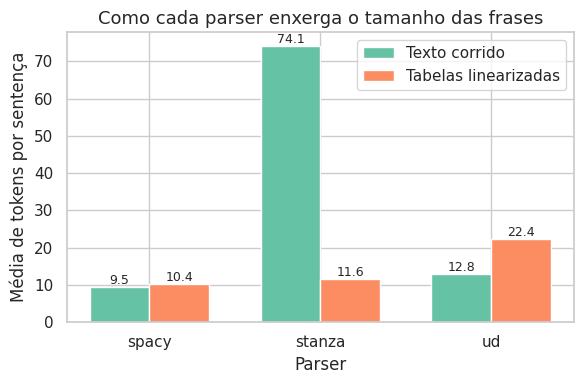

In [ ]:
grafico_barras_metricas(
    df_all,
    metric_col="n_tokens",
    titulo="Como cada parser enxerga o tamanho das frases",
    ylabel="Média de tokens por sentença",
    fmt="{:.1f}"
)

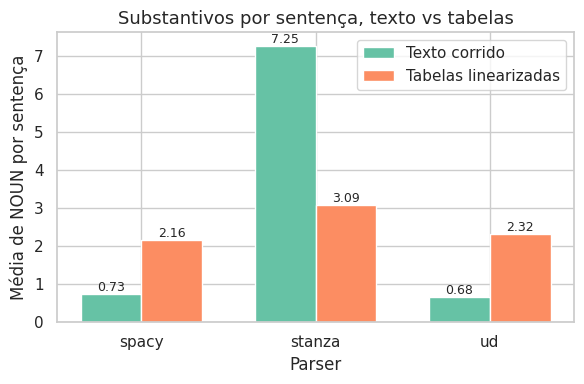

In [ ]:
grafico_barras_metricas(
    df_all,
    metric_col="n_NOUN",
    titulo="Substantivos por sentença, texto vs tabelas",
    ylabel="Média de NOUN por sentença",
    fmt="{:.2f}"
)

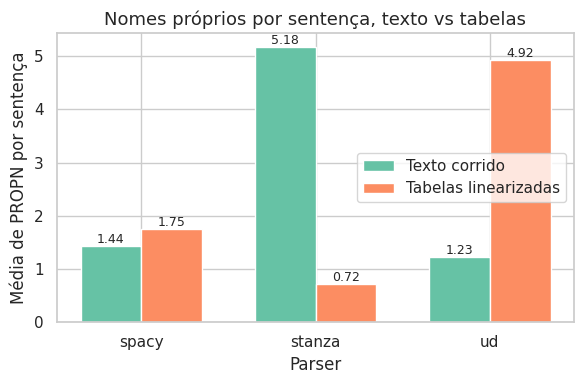

In [ ]:
grafico_barras_metricas(
    df_all,
    metric_col="n_PROPN",
    titulo="Nomes próprios por sentença, texto vs tabelas",
    ylabel="Média de PROPN por sentença",
    fmt="{:.2f}"
)

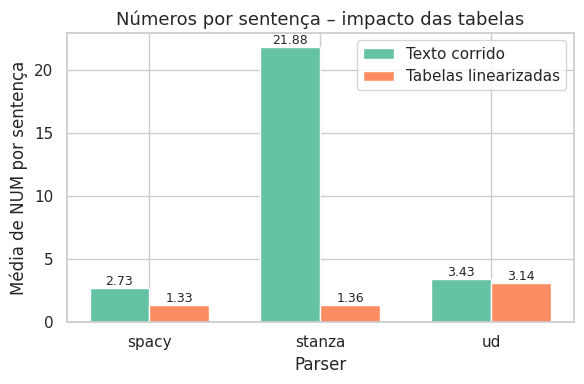

In [ ]:
grafico_barras_metricas(
    df_all,
    metric_col="n_NUM",
    titulo="Números por sentença – impacto das tabelas",
    ylabel="Média de NUM por sentença",
    fmt="{:.2f}"
)

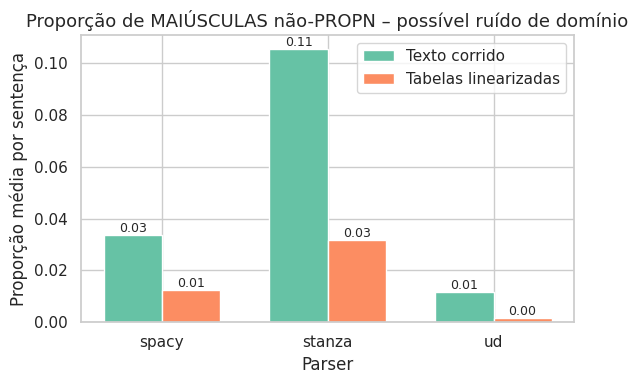

In [ ]:
grafico_barras_metricas(
    df_all,
    metric_col="perc_upper_not_propn",
    titulo="Proporção de MAIÚSCULAS não-PROPN – possível ruído de domínio",
    ylabel="Proporção média por sentença",
    fmt="{:.2f}"
)

# Sem docling

In [15]:
!pip install conllu spacy stanza ufal.udpip
#!python -m spacy download pt_core_news_lg
!python -m stanza.download pt

ERROR: Could not find a version that satisfies the requirement ufal.udpip (from versions: none)
ERROR: No matching distribution found for ufal.udpip
/usr/bin/python3: Error while finding module specification for 'stanza.download' (ModuleNotFoundError: No module named 'stanza')


In [1]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.0 MB/s eta 0:00:00


In [2]:
from PyPDF2 import PdfReader

In [4]:
INPUT_PDF = "/content/drive/MyDrive/IC/SIREVA/sireva_2023.pdf"
reader = PdfReader(INPUT_PDF)

In [5]:
texto_bruto = []
for page in reader.pages:
    page_text = page.extract_text()
    if page_text:
        texto_bruto.append(page_text)

texto_bruto = "\n".join(texto_bruto)
print("Tamanho do texto bruto:", len(texto_bruto))

Tamanho do texto bruto: 53299


## Spacy

In [8]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import spacy
from collections import Counter
import pandas as pd

In [9]:
nlp_spacy = spacy.load("pt_core_news_lg")
PRINCIPAIS_POS = ["NOUN", "PROPN", "VERB", "ADJ", "NUM"]

In [10]:
def sent_stats_spacy(texto: str, origem: str) -> pd.DataFrame:
    doc = nlp_spacy(texto)
    linhas = []

    for i, sent in enumerate(doc.sents):
        tokens = [t for t in sent if not t.is_space]
        n_tokens = len(tokens)
        pos_counts = Counter(t.pos_ for t in tokens)

        upper_tokens = [t for t in tokens if t.text.isupper() and not t.is_punct]
        upper_not_propn = [t for t in upper_tokens if t.pos_ != "PROPN"]

        linha = {
            "parser": "spacy",
            "origem": origem,
            "sent_id": i,
            "sent_text": sent.text.strip(),
            "n_tokens": n_tokens,
            "n_upper": len(upper_tokens),
            "n_upper_not_propn": len(upper_not_propn),
        }
        for pos in PRINCIPAIS_POS:
            linha[f"n_{pos}"] = pos_counts.get(pos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

df_spacy_bruto = sent_stats_spacy(texto_bruto, origem="pdf_bruto")
df_spacy_bruto.head()

,parser,origem,sent_id,sent_text,n_tokens,n_upper,n_upper_not_propn,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM
0,spacy,pdf_bruto,0,,0,0,0,0,0,0,0,0
1,spacy,pdf_bruto,1,SECRETARIA DE ESTADO DA SAÚDE \nCOORDENADORIA...,10,10,4,1,6,0,0,0
2,spacy,pdf_bruto,2,INSTITUTO ADOLFO LUTZ,3,3,1,1,2,0,0,0
3,spacy,pdf_bruto,3,2023,1,0,0,0,0,0,0,1
4,spacy,pdf_bruto,4,Informação da vigilância das pneumonias e \nme...,8,0,0,4,0,0,1,0


In [11]:
df_spacy_bruto.shape

(820, 12)

In [13]:
df_spacy_bruto.tail()

,parser,origem,sent_id,sent_text,n_tokens,n_upper,n_upper_not_propn,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM
815,spacy,pdf_bruto,815,Centro de Bacteriologia \nInstituto Adolfo Lu...,16,2,0,0,11,0,0,0
816,spacy,pdf_bruto,816,Ana Paula Silva de Lemos - ana.lemos@ial.sp.go...,13,0,0,0,10,0,0,0
817,spacy,pdf_bruto,817,Samanta Cristine Grassi Almeida -samanta.almei...,15,0,0,2,10,0,0,0
818,spacy,pdf_bruto,818,Claudia Patara Saraceni (coordenadora) \nAman...,24,1,0,1,15,0,0,0
819,spacy,pdf_bruto,819,"São Paulo, Brasil.",5,0,0,0,3,0,0,0


## Stanza

In [17]:
!pip3 install stanza

  Using cached stanza-1.11.0-py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 26.7 MB/s eta 0:00:00


In [18]:
import stanza

In [20]:
stanza.download("pt")

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: pt (Portuguese) ...


INFO:stanza:Downloaded file to /root/stanza_resources/pt/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [21]:
nlp_stz = stanza.Pipeline(lang="pt")

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: pt (Portuguese):
| Processor    | Package         |
----------------------------------
| tokenize     | bosque          |
| mwt          | bosque          |
| pos          | bosque_charlm   |
| lemma        | bosque_nocharlm |
| constituency | cintil_charlm   |
| depparse     | bosque_charlm   |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!


In [22]:
def sent_stats_stanza(texto: str, origem: str) -> pd.DataFrame:
    doc = nlp_stz(texto)
    linhas = []

    for i, sent in enumerate(doc.sentences):
        words = sent.words
        tokens_text = [w.text for w in words if w.text.strip() != ""]
        n_tokens = len(tokens_text)

        upos_counts = Counter(w.upos for w in words)

        upper_words = [w for w in words if w.text.isupper() and w.text.isalpha()]
        upper_not_propn = [w for w in upper_words if w.upos != "PROPN"]

        linha = {
            "parser": "stanza",
            "origem": origem,
            "sent_id": i,
            "sent_text": " ".join(tokens_text),
            "n_tokens": n_tokens,
            "n_upper": len(upper_words),
            "n_upper_not_propn": len(upper_not_propn),
        }
        for upos in PRINCIPAIS_POS:
            linha[f"n_{upos}"] = upos_counts.get(upos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

In [23]:
df_stanza_bruto = sent_stats_stanza(texto_bruto, origem="pdf_bruto")
df_stanza_bruto.head()

,parser,origem,sent_id,sent_text,n_tokens,n_upper,n_upper_not_propn,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM
0,stanza,pdf_bruto,0,SECRETARIA DE ESTADO DE A SAÚDE COORDENADORIA ...,14,14,12,7,2,0,0,0
1,stanza,pdf_bruto,1,2023,1,0,0,0,0,0,0,1
2,stanza,pdf_bruto,2,Informação de a vigilância de as pneumonias e ...,10,0,0,4,0,0,1,0
3,stanza,pdf_bruto,3,Sumário Introdução ..............................,16,0,0,3,3,0,0,2
4,stanza,pdf_bruto,4,Número de isolados invasivos por grupo etário ...,20,0,0,6,2,0,2,2


In [24]:
df_stanza_bruto.shape

(420, 12)

## UDPIPE

In [28]:
!pip install conllu ufal.udpipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 16.6 MB/s eta 0:00:00


In [33]:
from collections import Counter
from conllu import parse
from pathlib import Path

In [29]:
import urllib.request
import zipfile
import os
from ufal.udpipe import Model, Pipeline

In [30]:
url = "https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.5/master/inst/udpipe-ud-2.5-191206/portuguese-gsd-ud-2.5-191206.udpipe"
udpipe_model_path = "portuguese-gsd-ud-2.5-191206.udpipe"

urllib.request.urlretrieve(url, udpipe_model_path)

print("Modelo baixado em:", udpipe_model_path)

Modelo baixado em: portuguese-gsd-ud-2.5-191206.udpipe


testando novamente para ver se o modelo UD PIPE foi baixado

In [31]:
modelo_path = "portuguese-gsd-ud-2.5-191206.udpipe"

model = Model.load(modelo_path)
if not model:
    raise RuntimeError(f"Não foi possível carregar o modelo em {modelo_path}")

pipeline = Pipeline(
    model,
    "tokenize",        # etapa 1: tokenizacao
    Pipeline.DEFAULT,  # etapa 2: tagging (POS, feats)
    Pipeline.DEFAULT,  # etapa 3: parsing (dependencias)
    "conllu"           # formato de saida
)

texto_teste = "eh um teste do udp em portugues"
conllu_teste = pipeline.process(texto_teste)
print(conllu_teste)

# newdoc
# newpar
# sent_id = 1
# text = eh um teste do udp em portugues
1	eh	_	NOUN	NOUN	_	0	root	_	_
2	um	_	DET	DET	_	3	det	_	_
3	teste	teste	NOUN	NOUN	_	1	obj	_	_
4-5	do	_	_	_	_	_	_	_	_
4	de	de	ADP	ADP	_	6	case	_	_
5	o	o	DET	DET	Definite=Def|Gender=Masc|Number=Sing|PronType=Art	6	det	_	_
6	udp	_	NOUN	NOUN	_	3	nmod	_	_
7	em	_	ADP	ADP	_	8	case	_	_
8	portugues	portugue	NOUN	NOUN	_	1	nmod	_	SpacesAfter=\n




In [35]:
def processar_udpipe(texto: str, max_chars: int = 50000) -> str:
    """
    Processa texto longo em chunks para evitar crash.
    Retorna CoNLL-U concatenado de todas as partes.
    """
    saidas = []
    n = len(texto)
    inicio = 0

    while inicio < n:
        fim = min(inicio + max_chars, n)
        subtexto = texto[inicio:fim]

        conllu_parte = pipeline.process(subtexto)
        saidas.append(conllu_parte)

        print(f"[UDPipe] chunk {inicio}-{fim} processado")

        inicio = fim

    return "\n".join(saidas)

In [36]:
out_dir = Path("saida_corpus")
out_dir.mkdir(parents=True, exist_ok=True)

conllu_bruto = processar_udpipe(texto_bruto, max_chars=20000)

ud_bruto_path = out_dir / "ud_pdf_bruto.conllu"
ud_bruto_path.write_text(conllu_bruto, encoding="utf-8")

print("CoNLL-U bruto salvo em:", ud_bruto_path)

[UDPipe] chunk 0-20000 processado
[UDPipe] chunk 20000-40000 processado
[UDPipe] chunk 40000-53299 processado
CoNLL-U bruto salvo em: saida_corpus/ud_pdf_bruto.conllu


In [39]:
PRINCIPAIS_UPOS = ["NOUN", "PROPN", "VERB", "ADJ", "NUM"]

In [37]:
def sent_stats_udpipe(path_conllu: Path, origem: str) -> pd.DataFrame:
    """
    Le um arquivo CoNLL-U do UDPipe e gera um DataFrame com uma linha por sentenca:
    - parser: "ud"
    - origem: ex. "pdf_bruto"
    - sent_id
    - sent_text
    - n_tokens
    - n_upper
    - n_upper_not_propn
    - n_NOUN, n_PROPN, n_VERB, n_ADJ, n_NUM
    """
    texto_conllu = path_conllu.read_text(encoding="utf-8")
    sentencas = parse(texto_conllu)

    linhas = []

    for i, sent in enumerate(sentencas):
        # ignora multiword tokens (ids tipo 4-5)
        tokens = [t for t in sent if isinstance(t["id"], int)]

        n_tokens = len(tokens)
        upos_counts = Counter(t["upos"] for t in tokens)

        upper_tokens = [t for t in tokens if t["form"].isupper()]
        upper_not_propn = [t for t in upper_tokens if t["upos"] != "PROPN"]

        linha = {
            "parser": "ud",
            "origem": origem,
            "sent_id": i,
            "sent_text": " ".join(t["form"] for t in tokens),
            "n_tokens": n_tokens,
            "n_upper": len(upper_tokens),
            "n_upper_not_propn": len(upper_not_propn),
        }

        for upos in PRINCIPAIS_UPOS:
            linha[f"n_{upos}"] = upos_counts.get(upos, 0)

        linhas.append(linha)

    return pd.DataFrame(linhas)

In [40]:
df_ud_bruto = sent_stats_udpipe(ud_bruto_path, origem="pdf_bruto")

print(df_ud_bruto.shape)
df_ud_bruto.head()

(346, 12)


,parser,origem,sent_id,sent_text,n_tokens,n_upper,n_upper_not_propn,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM
0,ud,pdf_bruto,0,SECRETARIA DE ESTADO DE A SAÚDE COORDENADORIA ...,15,14,5,0,9,1,0,1
1,ud,pdf_bruto,1,Informação de a vigilância de as pneumonias e ...,13,0,0,4,2,0,1,0
2,ud,pdf_bruto,2,................................,1,0,0,0,0,0,0,0
3,ud,pdf_bruto,3,................................,1,0,0,0,0,0,0,0
4,ud,pdf_bruto,4,.........,1,0,0,0,0,0,0,0


In [41]:
df_sem_docling = pd.concat(
    [df_spacy_bruto, df_stanza_bruto, df_ud_bruto],
    ignore_index=True
)

df_sem_docling["origem"].value_counts(), df_sem_docling["parser"].value_counts()

(origem
 pdf_bruto    1586
 Name: count, dtype: int64,
 parser
 spacy     820
 stanza    420
 ud        346
 Name: count, dtype: int64)

In [42]:
df_sem_docling["perc_upper_not_propn"] = df_sem_docling.apply(
    lambda row: row["n_upper_not_propn"] / row["n_upper"] if row["n_upper"] > 0 else 0,
    axis=1
)

In [43]:
cols = [
    "n_tokens",
    "n_NOUN", "n_PROPN", "n_VERB", "n_ADJ", "n_NUM",
    "n_upper", "n_upper_not_propn", "perc_upper_not_propn"
]

resumo_sem_docling = (
    df_sem_docling
    .groupby("parser")[cols]
    .mean()
    .round(2)
    .reset_index()
)

resumo_sem_docling

,parser,n_tokens,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM,n_upper,n_upper_not_propn,perc_upper_not_propn
0,spacy,13.71,1.70,1.76,0.14,0.32,7.62,0.57,0.28,0.11
1,stanza,26.80,4.00,2.79,0.15,0.71,14.55,0.63,0.28,0.10
2,ud,32.77,2.84,5.00,0.31,0.58,17.98,1.29,0.42,0.06


In [44]:
resumo_sem_docling.to_excel("Resumo_Metricas_Parsers_sem_Docling.xlsx", index=False)

# Comparacao Final

In [65]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style="whitegrid", palette="Set2")

In [47]:
df_docling = pd.read_excel("Resumo_Metricas_Parsers_Docling.xlsx")
df_docling["pipeline_origem"] = "docling"

df_docling

,parser,origem,n_tokens,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM,n_upper,n_upper_not_propn,perc_upper_not_propn,pipeline_origem
0,spacy,tabelas_linearizadas,10.37,2.16,1.75,0.18,0.28,1.33,0.27,0.02,0.01,docling
1,spacy,texto_corrigido,9.48,0.73,1.44,0.25,0.15,2.73,0.24,0.05,0.03,docling
2,stanza,tabelas_linearizadas,11.64,3.09,0.72,0.09,0.58,1.36,0.34,0.05,0.03,docling
3,stanza,texto_corrigido,74.08,7.25,5.18,0.28,1.38,21.88,1.79,0.95,0.11,docling
4,ud,tabelas_linearizadas,22.36,2.32,4.92,1.41,0.71,3.14,0.80,0.00,0.00,docling
5,ud,texto_corrigido,12.82,0.68,1.23,0.05,0.18,3.43,0.28,0.04,0.01,docling


In [48]:
resumo_sem_docling["pipeline_origem"] = "pdf_bruto"
resumo_sem_docling

,parser,n_tokens,n_NOUN,n_PROPN,n_VERB,n_ADJ,n_NUM,n_upper,n_upper_not_propn,perc_upper_not_propn,pipeline_origem
0,spacy,13.71,1.70,1.76,0.14,0.32,7.62,0.57,0.28,0.11,pdf_bruto
1,stanza,26.80,4.00,2.79,0.15,0.71,14.55,0.63,0.28,0.10,pdf_bruto
2,ud,32.77,2.84,5.00,0.31,0.58,17.98,1.29,0.42,0.06,pdf_bruto


In [49]:
df_completo = pd.concat([df_docling, resumo_sem_docling], ignore_index=True)

In [50]:
pivot = df_completo.pivot_table(
    index="parser",
    columns="pipeline_origem",
    values=["n_tokens", "n_NOUN", "n_PROPN", "n_VERB", "n_ADJ", "n_NUM",
            "n_upper", "n_upper_not_propn", "perc_upper_not_propn"],
).round(2)

In [51]:
pivot

n_ADJ            n_NOUN             n_NUM           n_PROPN  \
pipeline_origem docling pdf_bruto docling pdf_bruto docling pdf_bruto docling   
parser                                                                          
spacy              0.22      0.32    1.44      1.70    2.03      7.62    1.60   
stanza             0.98      0.71    5.17      4.00   11.62     14.55    2.95   
ud                 0.44      0.58    1.50      2.84    3.28     17.98    3.08   

                           n_VERB           n_tokens           n_upper  \
pipeline_origem pdf_bruto docling pdf_bruto  docling pdf_bruto docling   
parser                                                                   
spacy                1.76    0.22      0.14     9.93     13.71    0.26   
stanza               2.79    0.18      0.15    42.86     26.80    1.06   
ud                   5.00    0.73      0.31    17.59     32.77    0.54   

                          n_upper_not_propn           perc_upper_not_propn  \
pipeline_origem pdf_bruto           docling pdf_bruto              docling   
parser                                                                       
spacy                0.57              0.04      0.28                 0.02   
stanza               0.63              0.50      0.28                 0.07   
ud                   1.29              0.02      0.42                 0.00   

                           
pipeline_origem pdf_bruto  
parser                     
spacy                0.11  
stanza               0.10  
ud                   0.06

In [52]:
pivot.to_excel('resumo_comparativo_final.xlsx')

In [61]:
metrics = [
    "n_ADJ", "n_NOUN", "n_NUM", "n_PROPN", "n_VERB",
    "n_tokens", "n_upper", "n_upper_not_propn",
    "perc_upper_not_propn",
]

linhas = []

In [62]:
for parser in pivot.index:              # spacy / stanza / ud
    for m in metrics:
        val_doc = pivot.loc[parser, (m, "docling")]
        val_pdf = pivot.loc[parser, (m, "pdf_bruto")]
        linhas.append({
            "parser": parser,
            "metric": m,
            "docling": float(val_doc),
            "pdf_bruto": float(val_pdf),
            "diff_pdf_minus_doc": float(val_pdf) - float(val_doc),
        })

df_clean = pd.DataFrame(linhas)
df_clean.head()

,parser,metric,docling,pdf_bruto,diff_pdf_minus_doc
0,spacy,n_ADJ,0.22,0.32,0.10
1,spacy,n_NOUN,1.44,1.70,0.26
2,spacy,n_NUM,2.03,7.62,5.59
3,spacy,n_PROPN,1.60,1.76,0.16
4,spacy,n_VERB,0.22,0.14,-0.08


In [69]:
df_clean.shape

(27, 5)

In [70]:
df_clean.to_excel('Comparativo_Parsers_ComDocling_SemDocling_Final.xlsx',index=False)

In [63]:
def plot_metric(metric_name: str, title: str, ylabel: str, fmt: str = "{:.2f}"):
    """
    Gera gráfico de barras comparando Docling x PDF bruto para uma métrica.
    metric_name: ex. "n_tokens", "n_NUM", "perc_upper_not_propn"
    """
    data = df_clean[df_clean["metric"] == metric_name].copy()
    parsers = data["parser"].tolist()
    doc_vals = data["docling"].tolist()
    pdf_vals = data["pdf_bruto"].tolist()

    x = np.arange(len(parsers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))

    b1 = ax.bar(x - width / 2, doc_vals, width, label="Docling")
    b2 = ax.bar(x + width / 2, pdf_vals, width, label="PDF bruto")

    ax.set_xticks(x)
    ax.set_xticklabels(parsers)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel)
    ax.legend()

    # coloca o valor em cima de cada barra
    for bars in (b1, b2):
        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                h,
                fmt.format(h),
                ha="center",
                va="bottom",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

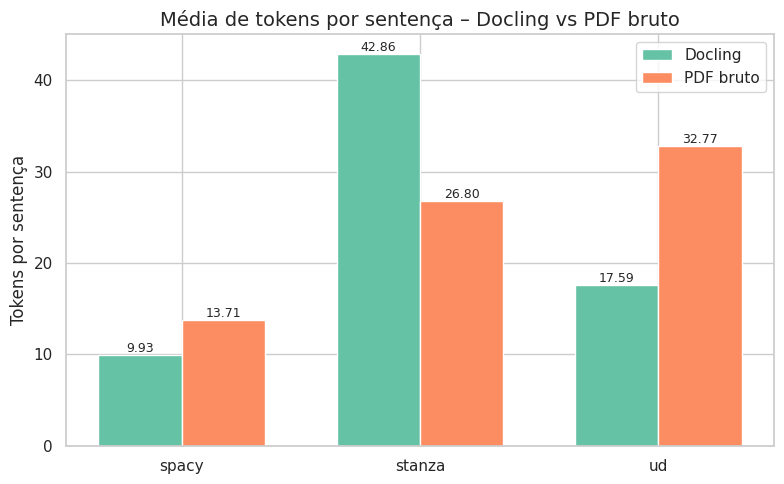

In [66]:
plot_metric(
    "n_tokens",
    "Média de tokens por sentença – Docling vs PDF bruto",
    "Tokens por sentença",
    fmt="{:.2f}",
)

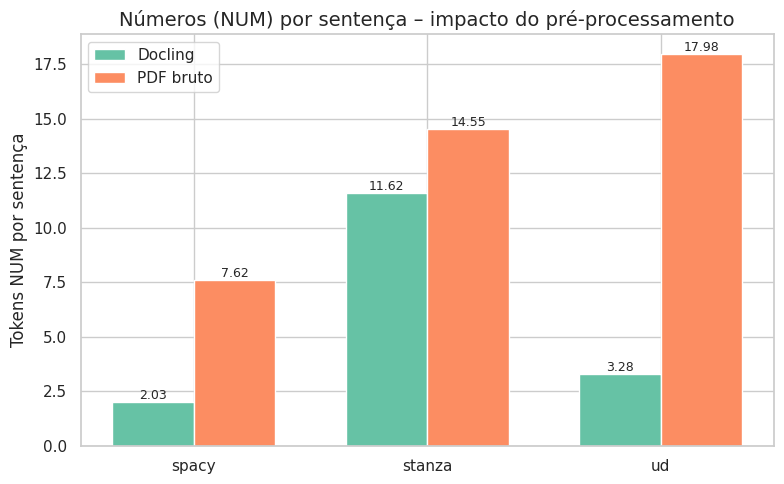

In [67]:
plot_metric(
    "n_NUM",
    "Números (NUM) por sentença – impacto do pré-processamento",
    "Tokens NUM por sentença",
    fmt="{:.2f}",
)

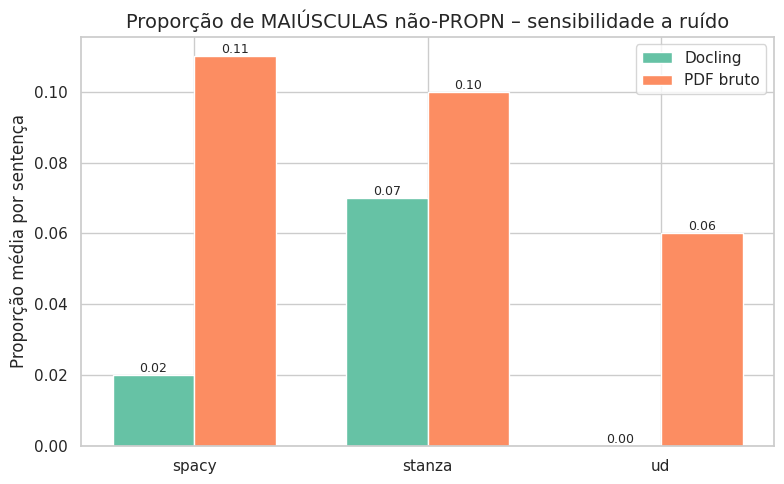

In [68]:
plot_metric(
    "perc_upper_not_propn",
    "Proporção de MAIÚSCULAS não-PROPN – sensibilidade a ruído",
    "Proporção média por sentença",
    fmt="{:.2f}",
)